##Data Collection and Training

In [2]:
import tensorflow
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import sklearn
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import classification_report, multilabel_confusion_matrix

#First, we import our data from two text files and partition it into training and validation data.

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# Load attributes csv
attributes = pd.read_csv("/content/drive/MyDrive/list_attr_celeba.txt", skiprows = 1, delimiter="\s+|\t")

# Load csv with partitions values
partitions = pd.read_csv("/content/drive/MyDrive/list_eval_partition.txt", delimiter="\s+|\t", header = None)

partitions.columns = ['image_name', 'dataset'] # setting column header names for partitions
attributes['dataset'] = partitions['dataset'].values # copying the partition values into the attributes df

#We unzip our images into another folder.
import zipfile
zippath = '/content/drive/MyDrive/img_align_celeba.zip'
targetfolder = 'all_images'

with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall(targetfolder)

# the image filenames need to be in their own column called "image_names"
attributes = attributes.reset_index()
attributes.rename(columns={'index': 'image_names'}, inplace=True)

#The data is already partitioned into train, validation, and test datasets, so we read
#these into separate dataframes in preparation for using ImageDataGenerators to
#load each of our images for training.
train = attributes[attributes['dataset'] == 0]
train.drop(columns='dataset', inplace=True)
train = train.iloc[:1000]
valid = attributes[attributes['dataset'] == 1]
valid.drop(columns='dataset', inplace=True)
valid = valid.iloc[:1000]
test = attributes[attributes['dataset'] == 2]
test.drop(columns='dataset', inplace=True)
test = test.iloc[:1000]

batch_size = 64

attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
                    'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling',
                    'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']

# replace all -1s with 0s for binary classification
for name in attribute_names:
  train[name].replace({-1: 0}, inplace=True)
  valid[name].replace({-1: 0}, inplace=True)
  test[name].replace({-1: 0}, inplace=True)

# Use ImageDataGenerator for train and valid datasets
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe for train and valid generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='all_images/img_align_celeba/',
    x_col="image_names",
    y_col=attribute_names,
    class_mode="raw",
    batch_size=batch_size,
    target_size=(109,89)
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid,
    directory='all_images/img_align_celeba/',
    x_col="image_names",
    y_col=attribute_names,
    class_mode="raw",
    batch_size=batch_size,
    target_size=(109,89)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='all_images/img_align_celeba/',
    x_col="image_names",
    y_col=attribute_names,
    class_mode="raw",
    batch_size=batch_size,
    target_size=(109,89)
)


Mounted at /content/drive


<ipython-input-2-c77d8bb96146>:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  attributes = pd.read_csv("/content/drive/MyDrive/list_attr_celeba.txt", skiprows = 1, delimiter="\s+|\t")
<ipython-input-2-c77d8bb96146>:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  partitions = pd.read_csv("/content/drive/MyDrive/list_eval_partition.txt", delimiter="\s+|\t", header = None)


Found 1000 validated image filenames.
Found 1000 validated image filenames.
Found 1000 validated image filenames.


<ipython-input-2-c77d8bb96146>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns='dataset', inplace=True)
<ipython-input-2-c77d8bb96146>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.drop(columns='dataset', inplace=True)
<ipython-input-2-c77d8bb96146>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns='dataset', inplace=True)


#Initial Sequential Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten


model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(109, 89, 3)))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Flatten())
model.add(Dense(units=32, activation="relu"))
model.add(Dense(units=40, activation="sigmoid"))
model.add(Dropout(0.1))
model.summary()

# Compile and train your model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    monitor = 'accuracy',
    restore_best_weights=True
)

model.fit_generator(generator=train_generator,
                    epochs=1000,
                    validation_data=valid_generator,
                    verbose=1,
                    callbacks = [early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 109, 89, 75)       2100      
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 89, 50)       33800     
                                                                 
 flatten_1 (Flatten)         (None, 485050)            0         
                                                                 
 dense_4 (Dense)             (None, 32)                15521632  
                                                                 
 dense_5 (Dense)             (None, 40)                1320      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
Total params: 15558852 (59.35 MB)
Trainable params: 15

<ipython-input-15-6a3460beccf1>:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


16/16 [==============================] - 4s 145ms/step - loss: 1.0892 - accuracy: 0.0070 - val_loss: 0.5872 - val_accuracy: 0.0000e+00
Epoch 2/1000
16/16 [==============================] - 2s 113ms/step - loss: 0.8911 - accuracy: 0.0000e+00 - val_loss: 0.5327 - val_accuracy: 0.0000e+00
Epoch 3/1000
16/16 [==============================] - 2s 109ms/step - loss: 0.8358 - accuracy: 0.0000e+00 - val_loss: 0.4973 - val_accuracy: 0.0060
Epoch 4/1000
16/16 [==============================] - 2s 113ms/step - loss: 0.7763 - accuracy: 0.0030 - val_loss: 0.4614 - val_accuracy: 0.0060
Epoch 5/1000
16/16 [==============================] - 2s 145ms/step - loss: 0.7525 - accuracy: 0.0040 - val_loss: 0.4427 - val_accuracy: 0.0060
Epoch 6/1000
16/16 [==============================] - 3s 181ms/step - loss: 0.7417 - accuracy: 0.0030 - val_loss: 0.4290 - val_accuracy: 0.0050


In [6]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 1s 51ms/step - loss: 0.4251 - accuracy: 0.0120
Test Loss: 0.4251396059989929
Test Accuracy: 0.012000000104308128



#Pre-Trained model

In [7]:
#We load the pretrained ImageNet ResNet50 model, remove the top layers,
#add our own pooling and dense layers, as well as a Dropout to prevent overfitting,
#freeze the base layers, and train the model.

input_shape = (109, 89, 3)
input_layer = Input(shape=input_shape)
resized_input = Resizing(224, 224)(input_layer) # resize images to 224x224 to fit ImageNet

# Load the pre-trained ResNet50 model (excluding the top classification layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=resized_input)

# Add custom layers on top of ResNet50
x = base_model(base_model.input, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_initializer=initializers.glorot_uniform())(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(40, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base ResNet50 layetrainrs
for layer in base_model.layers:
    layer.trainable = False

# Compile and train the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'binary_accuracy'])

# Define early stopping after 5 epochs
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    monitor = 'accuracy',
    restore_best_weights=True
)

# Train on the training data for 10 epochs
model.fit(train_generator,
                    epochs=10,
                    validation_data=valid_generator,
                   steps_per_epoch=train.shape[0]//batch_size,
                    validation_steps=valid.shape[0]//batch_size,
                    verbose=1,
                    callbacks = [early_stopping])

#We fine-tune the model by unfreezing the top 25 layers and training with a smaller learning rate.
for layer in model.layers[25:]:
    layer.trainable = True

# Recompile the model after fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
model.fit(train_generator, validation_data=valid_generator, steps_per_epoch=train.shape[0]//batch_size, epochs=10, callbacks = [early_stopping])

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
15/15 [==============================] - 21s 811ms/step - loss: 0.7110 - accuracy: 0.0278 - binary_accuracy: 0.5211 - val_loss: 0.7146 - val_accuracy: 0.0031 - val_binary_accuracy: 0.5134
Epoch 2/10
15/15 [==============================] - 8s 549ms/step - loss: 0.6748 - accuracy: 0.0502 - binary_accuracy: 0.5828 - val_loss: 0.6797 - val_accuracy: 0.0031 - val_binary_accuracy: 0.5650
Epoch 3/10
15/15 [==============================] - 8s 544ms/step - loss: 0.6454 - accuracy: 0.0479 - binary_accuracy: 0.6453 - val_loss: 0.6541 - val_accuracy: 0.0031 - val_binary_accuracy: 0.5938
Epoch 4/10
15/15 [==============================] - 6s 377ms/step - loss: 0.6104 - accuracy: 0.0662 - binary_accuracy: 0.7258 - val_loss: 0.6285 - val_accuracy: 0.0031 - val_binary_accuracy: 0.7024
Epoch 5/10
15/15 [==============================] - 5s 370ms/step - loss: 0.5745 - accuracy: 0.0363 - binary_accuracy: 0.7712 - val_loss: 0.58

#Evaluation

In [8]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 3s 190ms/step - loss: 0.6242 - accuracy: 0.0020
Test Loss: 0.6241723895072937
Test Accuracy: 0.0020000000949949026


Classification Report

In [16]:
for name in attribute_names:
  test[name].replace({-1: 0}, inplace=True)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='all_images/img_align_celeba/',
    x_col="image_names",
    y_col=attribute_names,
    class_mode="raw",
    batch_size=batch_size,
    target_size=(109,89)
)

predictions = model.predict(test_generator)
predictions_rounded = np.round(predictions)
true_labels = test_generator.labels
true_labels_binary = (true_labels == 1).astype(int)
true_labels_binary_reshaped = true_labels_binary.reshape(predictions_rounded.shape)


print(classification_report(true_labels_binary_reshaped, predictions_rounded, target_names=attribute_names))

Found 1000 validated image filenames.
16/16 [==============================] - 1s 50ms/step
                     precision    recall  f1-score   support

   5_o_Clock_Shadow       0.07      0.16      0.10        95
    Arched_Eyebrows       0.00      0.00      0.00       290
         Attractive       0.50      0.00      0.00       501
    Bags_Under_Eyes       0.00      0.00      0.00       191
               Bald       0.02      1.00      0.05        23
              Bangs       0.00      0.00      0.00       165
           Big_Lips       0.00      0.00      0.00       343
           Big_Nose       0.00      0.00      0.00       202
         Black_Hair       0.00      0.00      0.00       295
         Blond_Hair       0.00      0.00      0.00       131
             Blurry       0.06      1.00      0.11        61
         Brown_Hair       0.00      0.00      0.00       190
     Bushy_Eyebrows       0.00      0.00      0.00       125
             Chubby       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix (text)

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

# Define an empty array to store the predictions and true labels for all batches from the test generator
all_predictions = []
all_true_labels = []

# Loop through the test generator to obtain predictions and true labels for all batches
test_generator.reset()  # Reset the test generator to starttrue_labels = test_generator.labels from the beginning
for i in range(len(test_generator)):       # run for however many batches we want, I started with two because it took a while
    batch_data, batch_labels = test_generator.next()
    batch_predictions = model.predict(batch_data)
    all_predictions.append(batch_predictions)
    all_true_labels.append(batch_labels)


# Concatenate the predictions and true labels from all batches into single arrays
predictions = np.concatenate(all_predictions)
true_labels = np.concatenate(all_true_labels)

# Convert to binary
true_labels_binary = (true_labels == 1).astype(int)
predictions_binary = (predictions > 0.5).astype(int)

# Generate the multilabel confusion matrix
confusion_matrix = multilabel_confusion_matrix(true_labels_binary, predictions_binary)  # threshold

# Reshape and print the multilabel confusion matrix
confusion_matrix = confusion_matrix.reshape(40, 2, 2)
print(confusion_matrix)

2/2 [==============================] - 2s 1s/step
[[[905   0]
  [ 95   0]]

 [[710   0]
  [290   0]]

 [[ 68 431]
  [ 12 489]]

 [[809   0]
  [191   0]]

 [[977   0]
  [ 23   0]]

 [[835   0]
  [165   0]]

 [[657   0]
  [343   0]]

 [[798   0]
  [202   0]]

 [[705   0]
  [295   0]]

 [[869   0]
  [131   0]]

 [[939   0]
  [ 61   0]]

 [[810   0]
  [190   0]]

 [[875   0]
  [125   0]]

 [[934   0]
  [ 66   0]]

 [[126 825]
  [  1  48]]

 [[928   1]
  [ 71   0]]

 [[951   0]
  [ 49   0]]

 [[  0 972]
  [  0  28]]

 [[593   0]
  [407   0]]

 [[505   0]
  [495   0]]

 [[609   4]
  [353  34]]

 [[494   0]
  [506   0]]

 [[961   0]
  [ 39   0]]

 [[  0 854]
  [  0 146]]

 [[133   0]
  [867   0]]

 [[714   0]
  [286   0]]

 [[964   0]
  [ 36   0]]

 [[723   0]
  [277   0]]

 [[917   0]
  [ 83   0]]

 [[917   0]
  [ 83   0]]

 [[945  16]
  [ 37   2]]

 [[488   0]
  [512   0]]

 [[787   0]
  [213   0]]

 [[638   0]
  [362   0]]

 [[786   0]
  [214   0]]

 [[958   0]
  [ 42   0]]

 [[494   0]
  

Confusion Matrix (plots)

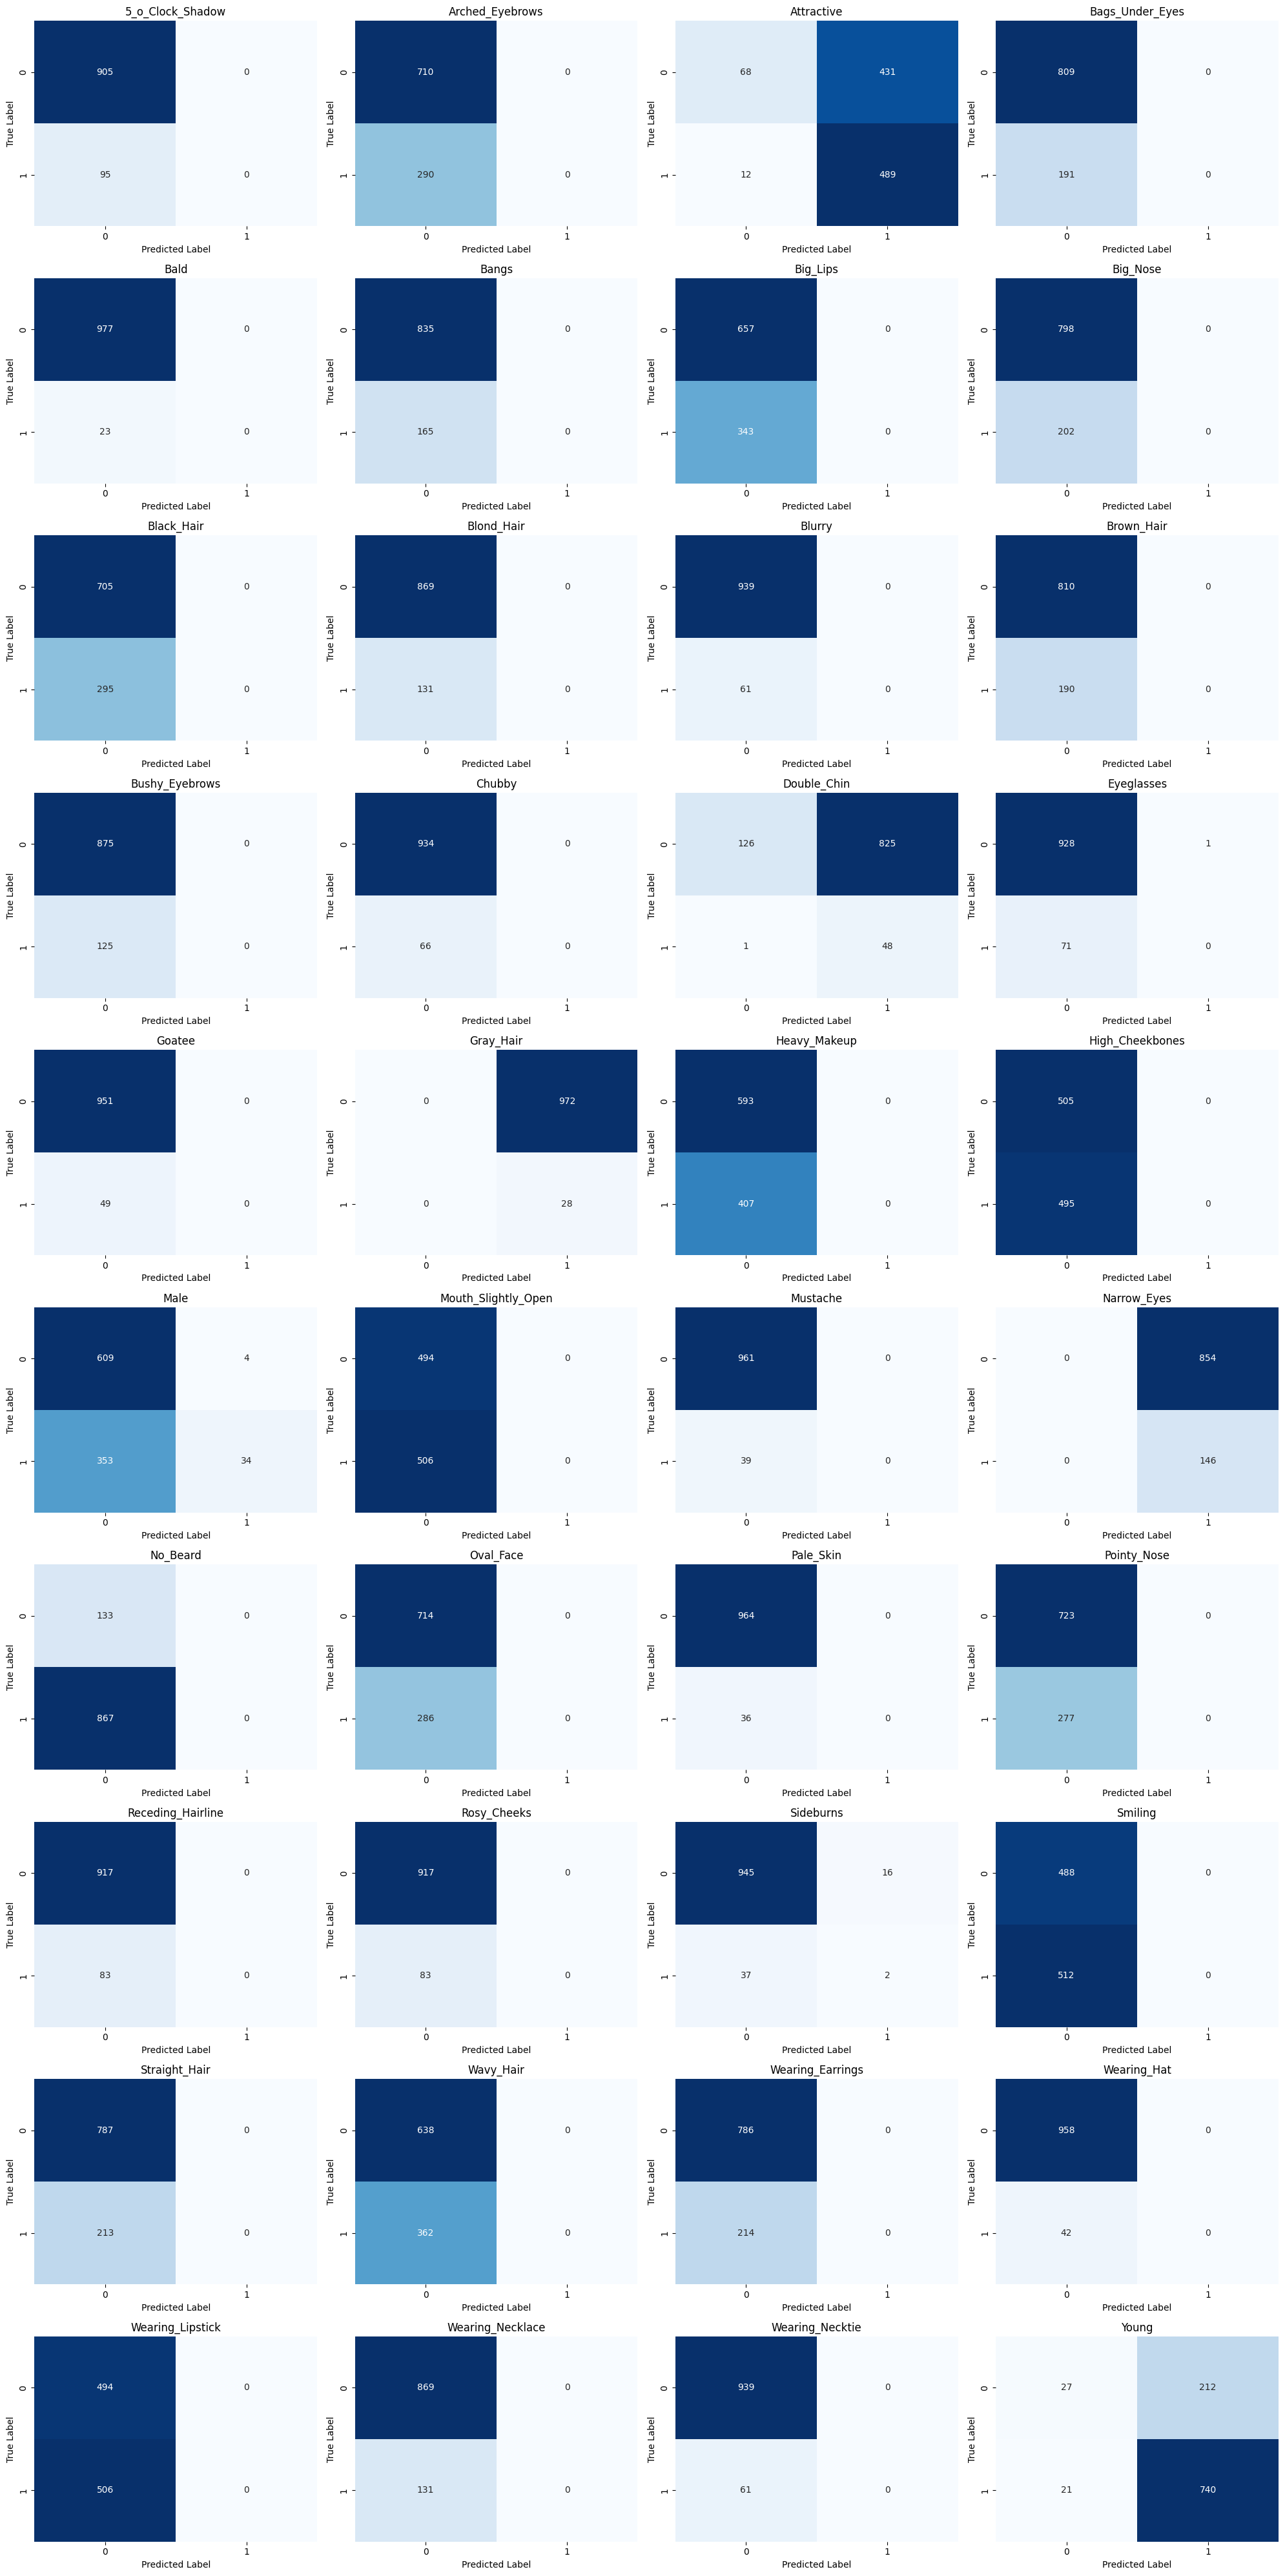

In [11]:
fig, axes = plt.subplots(10, 4, figsize=(20, 40))  # Create a 10x4 grid of subplots
for i in range(40):
    ax = axes[i // 4, i % 4]  # Get the current subplot
    sns.heatmap(confusion_matrix[i], annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(attribute_names[i])
plt.tight_layout()
plt.show()

Looking at the images in the data

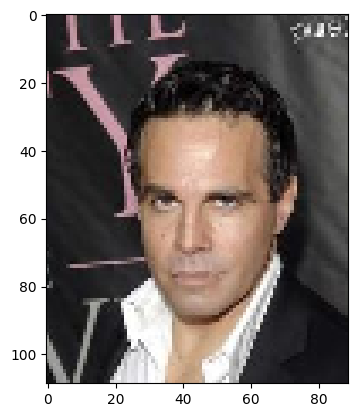

1/1 [==============================] - 1s 828ms/step
Probability of 5_o_Clock_Shadow: 0.3540
Probability of Arched_Eyebrows: 0.2116
Probability of Attractive: 0.5228
Probability of Bags_Under_Eyes: 0.4152
Probability of Bald: 0.4050
Probability of Bangs: 0.3938
Probability of Big_Lips: 0.3759
Probability of Big_Nose: 0.4144
Probability of Black_Hair: 0.4321
Probability of Blond_Hair: 0.2385
Probability of Blurry: 0.4371
Probability of Brown_Hair: 0.4037
Probability of Bushy_Eyebrows: 0.4539
Probability of Chubby: 0.4594
Probability of Double_Chin: 0.5012
Probability of Eyeglasses: 0.4825
Probability of Goatee: 0.3102
Probability of Gray_Hair: 0.5802
Probability of Heavy_Makeup: 0.3699
Probability of High_Cheekbones: 0.4470
Probability of Male: 0.4768
Probability of Mouth_Slightly_Open: 0.4494
Probability of Mustache: 0.4169
Probability of Narrow_Eyes: 0.5490
Probability of No_Beard: 0.4664
Probability of Oval_Face: 0.3570
Probability of Pale_Skin: 0.4229
Probability of Pointy_Nose: 0.4

In [12]:
def predict_single_image(model, img_path, target_size):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    plt.imshow(img)
    plt.show()
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch with a single sample
    img_array /= 255.0  # Normalize pixel values

    # Make predictions
    predictions = model.predict(img_array)
    return predictions

img_path = '/content/all_images/img_align_celeba/000008.jpg'
target_size = (109, 89)  # Specify the target size used during training

predictions = predict_single_image(model, img_path, target_size)
# Print predictions in a more readable way
for i, prob in enumerate(predictions[0]):
    print(f"Probability of {attribute_names[i]}: {prob:.4f}")

Looking at our own images

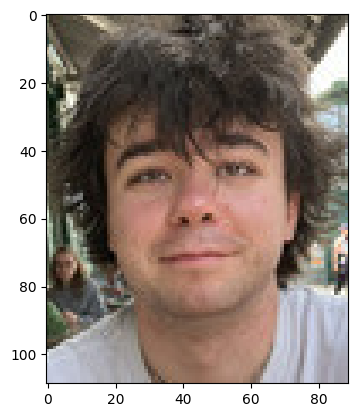

1/1 [==============================] - 0s 88ms/step
Probability of 5_o_Clock_Shadow: 0.3476
Probability of Arched_Eyebrows: 0.2087
Probability of Attractive: 0.5074
Probability of Bags_Under_Eyes: 0.4108
Probability of Bald: 0.4020
Probability of Bangs: 0.3909
Probability of Big_Lips: 0.3732
Probability of Big_Nose: 0.4142
Probability of Black_Hair: 0.4320
Probability of Blond_Hair: 0.2388
Probability of Blurry: 0.4375
Probability of Brown_Hair: 0.3999
Probability of Bushy_Eyebrows: 0.4539
Probability of Chubby: 0.4619
Probability of Double_Chin: 0.5035
Probability of Eyeglasses: 0.4835
Probability of Goatee: 0.3066
Probability of Gray_Hair: 0.5715
Probability of Heavy_Makeup: 0.3643
Probability of High_Cheekbones: 0.4543
Probability of Male: 0.4762
Probability of Mouth_Slightly_Open: 0.4482
Probability of Mustache: 0.4125
Probability of Narrow_Eyes: 0.5517
Probability of No_Beard: 0.4658
Probability of Oval_Face: 0.3585
Probability of Pale_Skin: 0.4133
Probability of Pointy_Nose: 0.42

In [14]:
def predict_real_picture(img_path):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.show()
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch with a single sample
    img_array /= 255.0  # Normalize pixel values

    # Make predictions
    predictions = model.predict(img_array)
    for i, prob in enumerate(predictions[0]):
      print(f"Probability of {attribute_names[i]}: {prob:.4f}")

# predict_real_picture("/content/drive/MyDrive/selfie.png")
predict_real_picture("/content/drive/MyDrive/sam.jpg")